### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.models import MLP
from ray import tune

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set

In [ ]:
from neuralforecast.utils import AirPassengersDF
# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
Y_df = AirPassengersDF
Y_df = Y_df.reset_index(drop=True)
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


Split data into **train** and **test**

In [ ]:
train_data = Y_df.head(132)
test_data = Y_df.tail(12)

Lets initialize and training model (**MLP**) and define its hyperparameters.

In [ ]:
horizon = 12
model = MLP(h=horizon, input_size=12,
            loss=DistributionLoss(distribution='Normal', level=[80, 90]),
            scaler_type='robust',
            learning_rate=1e-3,
            max_steps=200,
            val_check_steps=10,
            early_stop_patience_steps=2)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
fcst.fit(df=train_data, val_size=12)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | mlp          | ModuleList       | 1.1 M  | train
4 | out          | Linear           | 24.6 K | train
----------------------------------------------------------
1.1 M     Trainable params
5         Non-trainable params
1.1 M     Total params
4.350     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predict for the next defined horizon

In [ ]:
Y_hat_df = fcst.predict()
Y_hat_df.head()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,MLP,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90
unique_id,,,,,,,
1.0,1960-01-31,408.924683,408.840027,386.458618,391.899323,425.048157,429.648743
1.0,1960-02-29,392.037598,391.304260,361.825439,368.233765,416.101013,424.014893
1.0,1960-03-31,484.258087,484.340729,437.918213,448.213684,519.549988,531.080200
1.0,1960-04-30,468.928833,469.907593,420.667877,431.899353,505.866058,515.705750
1.0,1960-05-31,464.647125,466.234467,413.373505,424.859863,503.730225,512.233765


Measure the models accuracy

In [ ]:
calculate_error_metrics(test_data[['y']],Y_hat_df['MLP'])

MSE : 547.1603393554688
RMSE : 23.39145851135254
MAPE : 0.03406880423426628
r2 : 0.9012251869626534
adjusted_r2 : 0.8913477056589187


Visualize the predictions

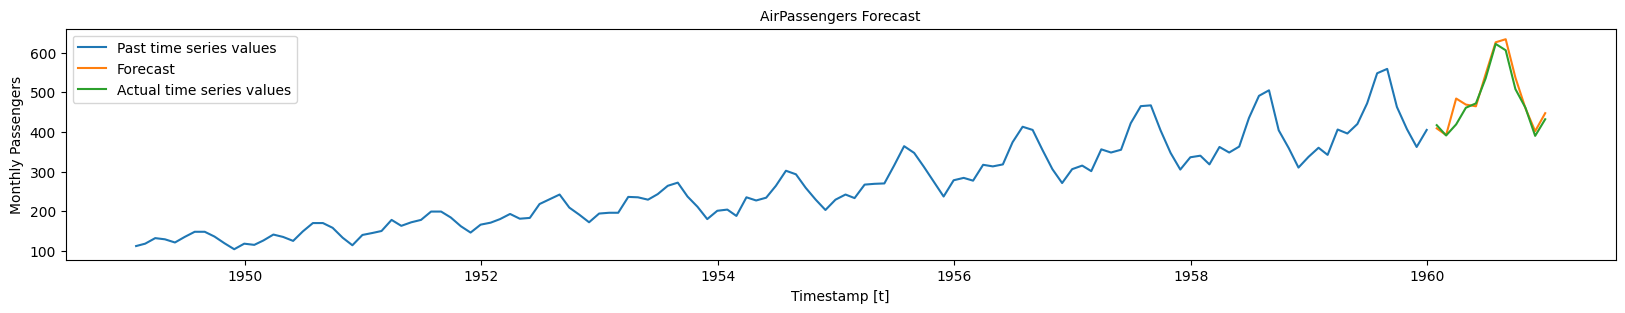

In [ ]:
train_data.set_index('ds',inplace =True)
Y_hat_df.set_index('ds',inplace =True)
test_data.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = train_data["y"]
y_pred = Y_hat_df['MLP']
y_test = test_data["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();